In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from math import sin
from math import cos
from math import sqrt
from math import pi

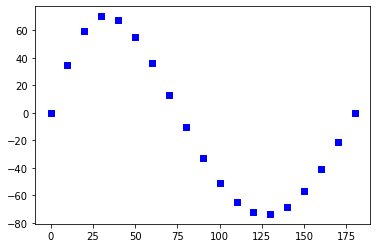

In [2]:
R0 = 10  #кпс
Q = 250  #км/c
r = 5

for l in range(0,190,10):
    x = r*cos((l-90)*pi/180)
    y = r*sin((l-90)*pi/180)
    R = sqrt(x*x+(y+R0)*(y+R0));
    
    fun = 250 + 4.05*(10-R)-1.62*(10-R)*(10-R);
    fy =  (fun*R0/R-Q)*sin(l*pi/180);
    
    plt.scatter(l,fy,color="blue",marker='s')

In [3]:
import time

def F_sun_vel(ra,dec,a,d,S_vel):
    """
        in:
          ra, dec - rad
          a,d - градусы
          S_vel - km/s           
        out:
          F_sun_vel - km/s
          Lang, 1980, p. 564, eq. 5-130 
    """    
    
    aa = a * (2*pi/360)  # ra_apeks (rad)
    da = d * (2*pi/360)  # dec_apeks (rad)
    
    return S_vel*(cos(aa)*cos(da)*cos(ra)*cos(dec)+
                  sin(aa)*cos(da)*sin(ra)*cos(dec)+
                  sin(da)*sin(dec))


def F_earth_vel(ra,dec,t):
    """
        in:
          ra, dec - rad
          t - time
          out:
          F_earth_vel - km/s
    """
    
    # https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
    
    e = 0.01671022 # Orbital eccentricity
    v = 29.78   # average orbital speed km/s
    
    year = time.localtime(t).tm_year
    day =  time.localtime(t).tm_yday #порядковый номер дня наблюдений
    
    if day>80:
        day = day - 80
    else:
        day = 365 - 80 + day

    day_rad = ((2*pi)/365.25)*day    #долгота Солнца

    T = (year-2000 + day*1./365 )*1./100
    gamma = (1018578.046 + 6190.046*T + 1.666*T*T + 0.012*T*T*T )/3600  # degree
    gamma = (2*pi/360)*gamma # rad

    naklon = ( 23*3600+26*60+19.81 - 0.47*(year-2000) )/3600 #degree
    naklon = (2*pi/360)*naklon #rad

    v_earth_1 = -v*(sin(day_rad)*cos(dec)*cos(ra) - 
                    cos(day_rad)*(cos(dec)*sin(ra)*cos(naklon) + 
                                  sin(dec)*sin(naklon))) 
    v_earth_2 = v*e*(sin(gamma)*cos(dec)*cos(ra) -
                     cos(gamma)*(cos(dec)*sin(ra)*cos(naklon) +
                                 sin(dec)*sin(naklon)))  # km/s
    return v_earth_1 + v_earth_2


In [4]:
from scipy.constants import speed_of_light # in vacuum  299792458.0 m s^-1
#import time

#apeks  {year: [aapeks,dapeks]}
# координаты апекса для разных эпох взяты из Крауса (с. 51)
apeks = {"2000":[271.6,29.2],
         "1950":[271.1,29.2],
         "1900":[270.6,29.2]}

#Скорость Солнца

S_vel = (19.5, # скорость взята из Ленга (ч.II, c.250))
               # Lang, 1980, p. 554, eq. 5-9 
         19.7) # скорость взята из Крауса (с. 51)


Fr = 25.330e6
y = '2000'
aapeks = apeks[y][0]
dapeks = apeks[y][1]

"""
3c461
23 23 24 +58 48.9
23 21 08 +58 32.4
"""
ra = (23 + 21.0/60 + 8.0*3600)*pi/180
dec  = (58 + 32.4/60)*pi/180

#CasA ew 23:00  d_2005_5_6_casa.001
obs_time = time.mktime((2005,5,6,23,0,0,0,0,0))

print(f'frequency = {Fr}')

v_sun = F_sun_vel(ra,dec,aapeks,dapeks,S_vel[1])
f_sun = v_sun*1000*Fr/speed_of_light

print(f'v_sun = {v_sun:8.4f}  км/с  f_sun = {f_sun:8.4f} Гц')

v_earth = F_earth_vel(ra,dec,obs_time)
f_earth = -v_earth*1000*Fr/speed_of_light

print(f'v_earth = {v_earth:8.4f}  км/с  f_earth = {f_earth:8.4f} Гц')

print(f'Dopler shift = {f_sun+f_earth:8.4f} Гц')

print(f'Скорость Солнца = {S_vel[1]:4.1f} км/с, эпоха {y}, Аппекс (ra,dec)=({aapeks:4.1f},{dapeks:4.1f})')

frequency = 25330000.0
v_sun =   4.8724  км/с  f_sun = 411.6741 Гц
v_earth =   0.2685  км/с  f_earth = -22.6853 Гц
Dopler shift = 388.9888 Гц
Скорость Солнца = 19.7 км/с, эпоха 2000, Аппекс (ra,dec)=(271.6,29.2)


In [5]:
# from math import pow
def carbonrrlfreq(nn,dn,flag):
    """
    если flag=1 вычисляет частоты РРЛ используя формулу Ридберга,
    если flag=2 вычисляет расстояние между соседними РРЛ.
    nn - главное квантовое число, функция возвращает значение частоты в Гц
    
    если flag=0 вычисляет приближенное значение главного квантового числа
    nn - частота в Гц, функция возвращает номер ближайшего "слева" главного квантового числа
    
    """

    light_vel = 2.99792458e+10   #скорость света в [cм/с]
    electronmass = 9.10938188e-28  #масса электрона [г]
    #protonmass = 1.67265e-24     #масса протона  [г] 
    #neutronmass = 1.67492728e-24 #масса нейтрона [г]
    aemass = 1.66057e-24      #атомная единица массы [г]
    rydberg = 109737.31568525 #постоянная Ридберга [cм-1]
    
    
    Z = 1    # заряд ядра углерода
    aem = 12 # атомная масса ядра углерода
    M = aemass*aem;  #масса атомного ядра углерода  (книга Сороченко)
    #M = 4*protonmass + (aem - 4)*neutronmass; //верно для Углерода, но Сороченко использовал предъидущую формулу
    carbon_rydberg = rydberg*(1-electronmass/M);

    switcher = { 
        0: (int)(pow(2*carbon_rydberg*Z*Z*light_vel*dn/(nn),1./3)), 
        1: Z*Z*light_vel*carbon_rydberg*(1./(nn*nn)-1./((nn+dn)*(nn+dn))), 
        2: 6*Z*Z*light_vel*carbon_rydberg*dn/pow(nn,4), 
    } 
    return switcher.get(flag, -1) 
    
    """
      switch (flag) {
         case 0: retvalue = (int)pow(2*carbon_rydberg*Z*Z*light_vel*dn/(nn*1.e3),1./3);break;
         case 1: retvalue = 1.e-3*Z*Z*light_vel*carbon_rydberg*(1./(nn*nn)-1./((nn+dn)*(nn+dn)));break;
         case 2: retvalue = 1.e-3*6*Z*Z*light_vel*carbon_rydberg*dn/pow(n,4);break;
         default : retvalue = -1;
      }
      return retvalue;
    """
    
nst = carbonrrlfreq(Fr,1,0)
fr = carbonrrlfreq(nst,1,1)
print(f'n = {nst}  f = {fr:0.3f}    F = {Fr}')


n = 638  f = 25275689.125    F = 25330000.0


In [6]:
time.localtime(time.mktime((2008,3,21,23,0,0,0,0,0))).tm_yday 

81